# Airbnb - Price Modelling
#### How to use OpenStreetMap for Feature Engineering and Price Prediction


### Table of Contents
* [Introduction](#introduction)
    * [Business Understanding](#business-understanding)
    * [Data Understanding](#data-understanding)
* [Methods](#methods)
    * [Setup](#set-up)
    * [Data Engineering](#data-enginering)
    * [Outlier Removal](#outlier-removal)
    * [Missing Data](#missing-data)
    * [Data Exploration](#data-exploration)
* [Results/Business Understanding](#results-business-understanding)
    * [Where are the most listings in Vienna?](#results-most-listings)
    * [How does the district affect the price?](#results-price-district)
    * [What types of listings are available?](#results-listings-type)
    * [How do weekends affect pricing?](#results-weekend-price)
    * [How is the number of reviews changing over time?](#results-reviews-over-time)    
    * [How can OpenStreetMap Location Data can be utilized for price prediction?](#osm-features)   
    
        

### Introduction <a class="anchor" id="introduction"></a>
Airbnb operates as an online marketplace focused on short-term homestays and experiences. The company acts as a broker and charges a commission from each booking. It connects hosts and travelers and enables the process of renting without owning any rooms itself. Airbnb cultivates the sharing economy which allows property owners to rent out private flats. In this sense it is a community-based online platform for listing and renting local homes.

The projects aim is to do a analysis as part of Udacity's Data Science Nanodegree and is structured according to the Cross-Industry Standard Process for Data Mining (CRISP-DM).

#### Business Understanding <a class="anchor" id="business-understanding"></a>
Defining the purpose of this analysis the following business questions are proposed:

- Where are the most listings in Vienna?
- How does the district affect the price?
- What types of listings are available?
- How do weekends affect pricing?
- How can OpenStreetMap Location Data can be utilized for price prediction?

#### Data Understanding <a class="anchor" id="data-understanding"></a>
These questions will be addressed in the analysis of the data provided by inside Airbnb [data](http://insideairbnb.com/get-the-data).

### Methods <a class="anchor" id="methods"></a>
#### Setup <a class="anchor" id="setup"></a>
Import libraries and load the data. In case the package is not installed use the following code for installation:

```python
import sys
!{sys.executable} -m pip install geojson
# alternative: pip install osmnx --user
```


In [1]:
# import modules/libraries
import warnings 
warnings.simplefilter(action='ignore')
import osmnx as ox
import pandas as pd
import numpy as np
import geopandas as gpd
import time
from scipy import stats
import itertools
import os
import pickle
import geojson
from sqlalchemy import create_engine
import re
import sqlite3
from pathlib import Path
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
import chardet
from scipy import spatial
from scipy.spatial import KDTree
cwd = Path().resolve()

# visualisation
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
import matplotlib as mpl 
%matplotlib inline 
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

#### Data Engineering <a class="anchor" id="data-engineering"></a>

In [2]:
# import the airbnb data
df = pd.read_csv(os.path.join(Path(cwd).parent, 'data', 'listings.csv.gz'), encoding='utf-8')
df.drop(['listing_url', 'host_picture_url', 'host_verifications', 'host_thumbnail_url', 'host_about', 'neighborhood_overview', 'picture_url', 'scrape_id', 'neighbourhood_group_cleansed', 'calculated_host_listings_count_shared_rooms', 'calculated_host_listings_count_private_rooms','calculated_host_listings_count_entire_homes'], axis=1, inplace=True)
df = df[['id', 'name','description', 'host_name','host_since', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost','host_listings_count','host_total_listings_count', 'host_has_profile_pic','host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities','price']]
df['neighbourhood'] = df['neighbourhood_cleansed']
df.drop(['neighbourhood_cleansed'], axis=1, inplace=True)

df_cal = pd.read_csv(os.path.join(Path(cwd).parent, 'data', 'calendar.csv.gz'), encoding='utf-8')
df_rev = pd.read_csv(os.path.join(Path(cwd).parent, 'data', 'reviews.csv'), index_col=False, sep=",")

#####  Get propper unicode coding for pandas import:

```python
with open(os.path.join(Path(cwd).parent, 'data', 'listings.csv.gz'),'rb') as f:
        data = f.read(800000)
encoding=chardet.detect(data).get("encoding")
```

In [3]:
df_cal.head(1)

listing_id        date available    price adjusted_price  minimum_nights  \
0       15883  2022-09-12         f  $110.00        $110.00             1.0   

   maximum_nights  
0           365.0

In [4]:
def aggregate_data(df, group='', agge='', rename=''):
    """ function to group, aggregate and rename the dataframe """
    df = df.groupby([group]).agg(agge)
    df.columns = df.columns.droplevel(0)
    df.columns = rename
    df.reset_index(drop=True, inplace=True)
    return df


def tukey_rule(data_frame, column_name):
    """ apply tukey rule to remove outliers """
    data = data_frame[column_name]
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    max_value = Q3 + 1.5 * IQR
    min_value = Q1 - 1.5 * IQR

    return data_frame[(data_frame[column_name] < max_value) & (data_frame[column_name] > min_value)]


def visualize_outliers(df, title):
    """ """
    fig = go.Figure()
    for district in df['neighbourhood'].unique().tolist()[0:3]:
        fig.add_trace(go.Violin(x=df['neighbourhood'][df['neighbourhood'] == district],
                                y=df['price'][df['neighbourhood'] == district],
                                name=district, legendgroup='neighbourhood',
                                line_color='blue',
                                width=0.8, box_visible=True, meanline_visible=True))
    fig.update_layout(font=dict(family="Helvetica"))
    fig.update_traces(box_visible=True, meanline_visible=True)
    fig.update_layout(violinmode="overlay", violingap=0)
    fig.update_layout(violinmode='group')
    fig.update_layout(title=title)
    fig.update_layout(yaxis_title="Median price in $")
    fig.update_layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)')
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.update_layout(autosize=False,width=700,height=400)
    fig.show()

    
def get_price(price_string):
    """ convert the price string into float """
    try:
        price_string = price_string.replace(' ', '')
        pattern = re.compile(r'\d{1,3}(?:[.,]\d{3})*(?:[.,]\d{2})?')
        return float(pattern.findall(price_string)[0].replace(',',''))
    except:
        print(price_string)

def remove_pct(rate):
    """ """
    try:
        return int(rate.replace('%', ''))
    except:
        return np.nan
        
        
def convert_dtype(df, cols_cur):
    """convert price & adjusted price dtype from object to float (without $) """
    for col in cols_cur:
        df[col] = df[col].str.replace('$','')
        df[col] = df[col].str.replace(',', '').astype(float)


df['host_response_rate'] = df.apply(lambda x: remove_pct(x['host_response_rate']), axis=1)
df['host_acceptance_rate'] = df.apply(lambda x: remove_pct(x['host_acceptance_rate']), axis=1)
df['id'] = df['id'].astype('category')
pd.to_numeric(df['host_response_rate'])
pd.to_numeric(df['host_acceptance_rate'])

convert_dtype(df_cal, ['price', 'adjusted_price'])
df_cal['date'] = pd.to_datetime(df_cal['date'])
df_cal['available'] = df_cal['available'].apply(lambda x: 1 if x == 't' else 0)
df_cal['weekend'] = np.where((pd.DatetimeIndex(df_cal.date).dayofweek==4) | (pd.DatetimeIndex(df_cal.date).dayofweek==5), True, False)
df_cal = df_cal.merge(df[['id', 'name', 'host_since', 'neighbourhood', 'host_is_superhost', 'latitude', 'longitude', 'room_type']], how='left', left_on='listing_id', right_on='id')

In [5]:
df['price'] = df.apply(lambda x: get_price(x['price']), axis=1)

df['neighbourhood'] = df['neighbourhood'].str.replace('Landstra§e', 'Landstraße')
df['neighbourhood'] = df['neighbourhood'].str.replace('Rudolfsheim-Fnfhaus', 'Rudolfsheim-Fünfhaus')
df['neighbourhood'] = df['neighbourhood'].str.replace('Dbling', 'Döbling')
df['neighbourhood'] = df['neighbourhood'].str.replace('Whring', 'Währing')


# set data types
df_rev['date'] = pd.to_datetime(df_rev['date'])
df['host_since'] = pd.to_datetime(df['host_since'])
df['host_for'] = (pd.to_datetime('2022-11-05')-df['host_since']).dt.days# / pd.Timedelta(hours=1) #.astype('timedelta64[h]')
pd.to_numeric(df['host_for'])
df.head(1)

id                       name  \
0  15883  b&b near Old Danube river   

                                         description host_name host_since  \
0  Four rooms, each one differently and individua...       Eva 2009-12-11   

  host_response_time  host_response_rate  host_acceptance_rate  \
0       within a day                50.0                  33.0   

  host_is_superhost  host_listings_count  host_total_listings_count  \
0                 f                  4.0                        6.0   

  host_has_profile_pic host_identity_verified neighbourhood  latitude  \
0                    t                      t    Donaustadt  48.24262   

   longitude              property_type   room_type  accommodates  \
0   16.42767  Room in bed and breakfast  Hotel room             3   

   bathrooms_text  bedrooms  beds  \
0  1 private bath       1.0   2.0   

                                           amenities  price  host_for  
0  ["Essentials", "Heating", "High chair", "Hange...  110.0    4712.0

#### Outlier Removal  <a class="anchor" id="outlier-removal"></a>

In [6]:
df_orig = df.copy()

for column in ['price']:
    df = tukey_rule(df, column)
    
visualize_outliers(df_orig, 'Prices of original data set')
visualize_outliers(df, 'Prices after outlier removal')

#### Missing Data  <a class="anchor" id="missing-data"></a>

In [7]:
# Missing data percent wise of the column
dfm = round(df.isnull().mean()*100,2)
missing_value_df = pd.DataFrame({'column': dfm.index, 'percentage': dfm.values}).sort_values('percentage', ascending=False)
missing_value_df.head(10)

column  percentage
5       host_response_time       31.58
6       host_response_rate       31.58
7     host_acceptance_rate       28.10
20                bedrooms       10.17
2              description        2.07
21                    beds        1.26
1                     name        0.10
19          bathrooms_text        0.06
12  host_identity_verified        0.02
11    host_has_profile_pic        0.02

### Data Exploration  <a class="anchor" id="data-exploration"></a>

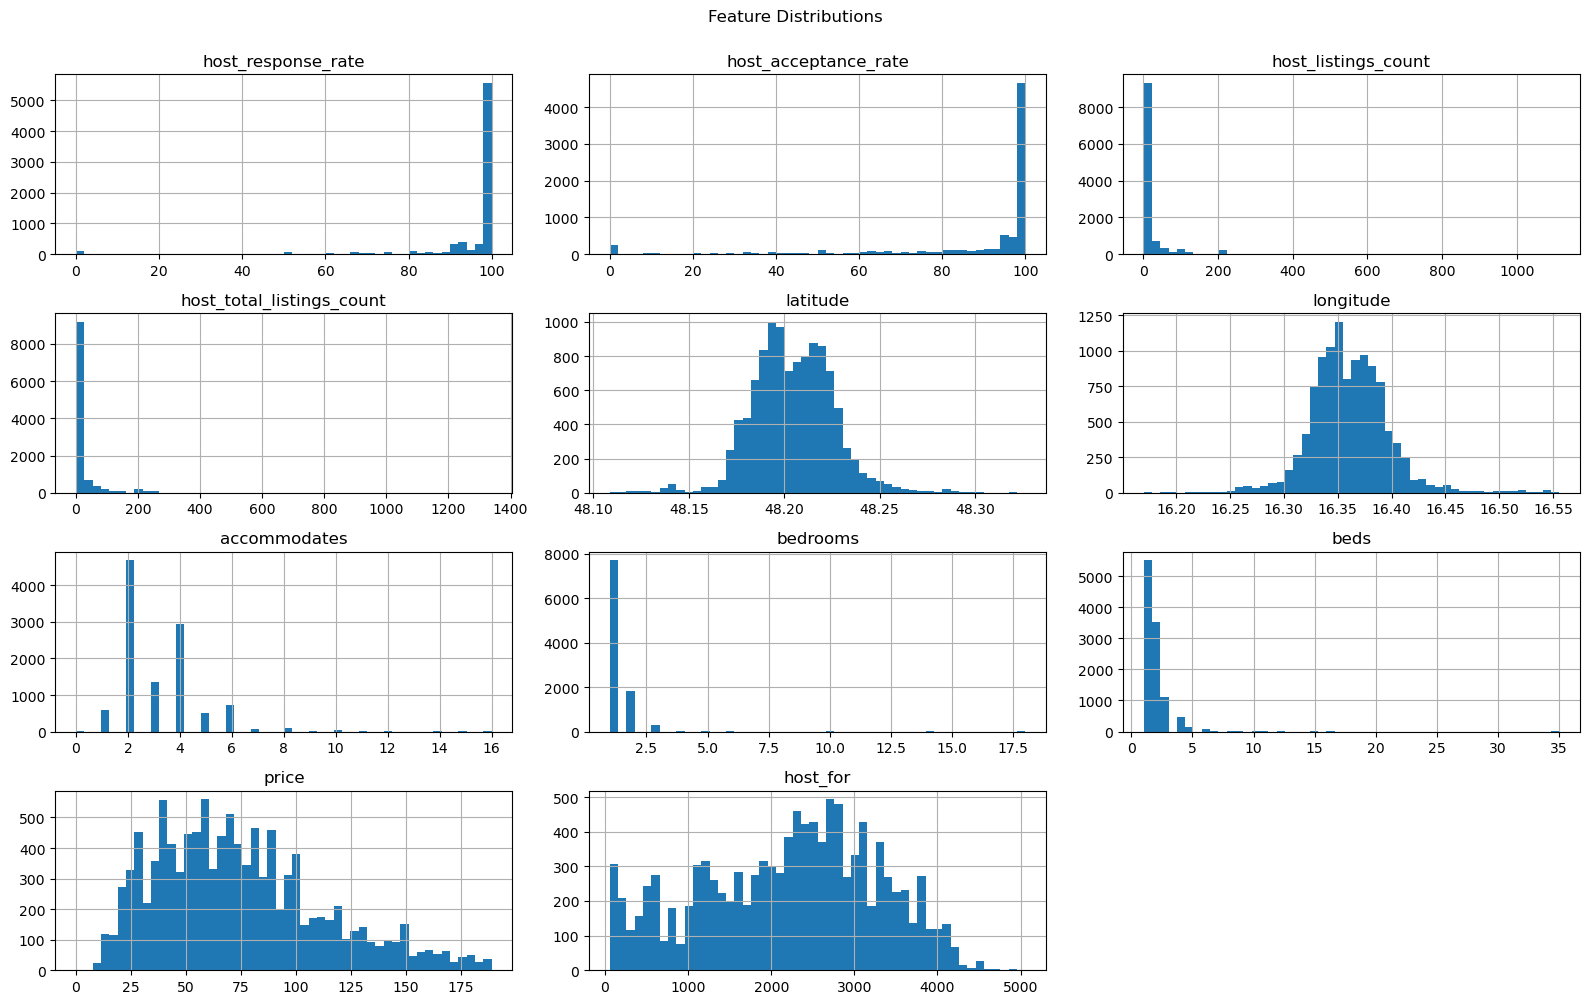

In [8]:
# numerical data exploration
df.select_dtypes(include=np.number).hist(figsize=(16, 10), bins=50, log=False)
plt.suptitle('Feature Distributions', y=1.0)
plt.tight_layout()

In [9]:
def categorical_distribution(df, column, table):
    """
    Aggregates and sorts categorical data of one independent variable and plots bar chart with normal and log scale 
    INPUT:
        df - dataframe with selected data
        column - column with independent variable to be aggregated and sorted     
    OUTPUT:
        2 bar charts: left bar chart shows independent variable with normal scale count and 
        right bar chart shows independent variable with logaritmic scale count
    """
    agg = df.groupby(column).agg(nr_listings = ('id', 'count')).reset_index()\
                         .sort_values('nr_listings', ascending = False)
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))

    agg.plot(x = column, y = 'nr_listings', kind = 'bar', ax = ax[0], legend = False, grid = True, log = False)
    ax[0].set_ylabel('number listings')
    ax[0].set_xlabel('')

    agg.plot(x = column, y = 'nr_listings', kind = 'bar', ax = ax[1], legend = False, grid = True, log = True)
    ax[1].set_title('log scale')
    ax[1].set_ylabel('log (number listings)')
    ax[1].set_xlabel('')
    
    fig.suptitle(('distribution number listings over ' + column.title()), y = 1.05)
    fig.tight_layout()
    
    agg['proportion [%]'] = round(100 * agg['nr_listings'] / agg['nr_listings'].sum(), 1)
    return agg

#### What types of listings are available? <a class="anchor" id="results-listings-type"></a>

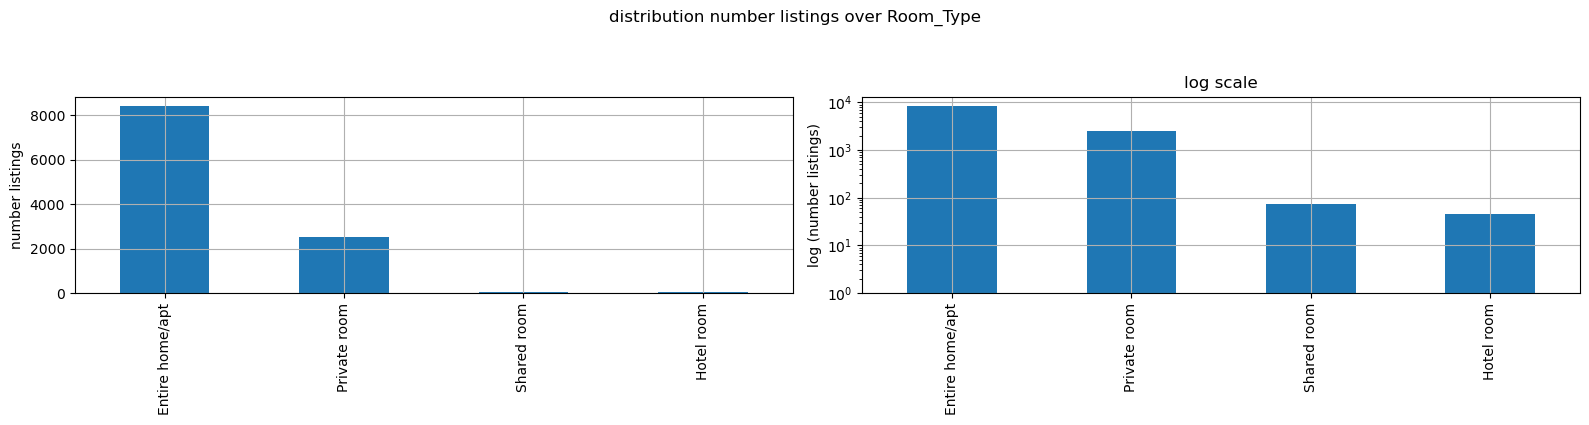

In [10]:
# display bar charts for all columns with categorical data in normal and  logarithmic scale
neigh = categorical_distribution(df, 'room_type', table=False)

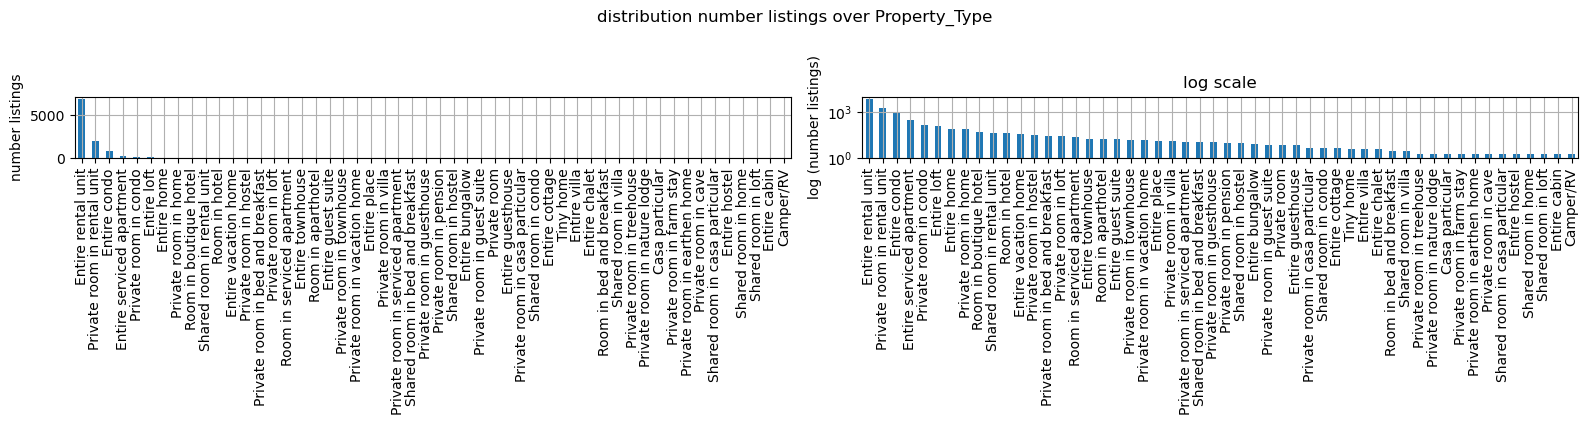

In [11]:
property_type = categorical_distribution(df, 'property_type', table=False)

Airbnb hosts can list entire homes/apartments, private, shared rooms, and more recently hotel rooms. 
Depending on the room type and activity, a residential airbnb listing could be more like a hotel, disruptive for neighbours, taking away housing, and illegal.

### Business Understanding  <a class="anchor" id="results-business-understanding"></a>
#### Where are the most listings in Vienna? <a class="anchor" id="results-most-listings"></a>

In [12]:
def get_geo_data():
    """ load geojson data """
    with open(os.path.join(Path(cwd).parent, 'data', 'geojson', 'vienna.geojson'), encoding='utf-8') as fp:
        counties = geojson.load(fp)
    return counties

In [13]:
def heatmap_airbnb2(title=''):
    """ """
    districts = get_geo_data()
    k = aggregate_data(df, 'neighbourhood', {'neighbourhood':['first'], 'price':['median'], 'host_is_superhost': ['first']},\
                       rename=['district', 'median', 'host_is_superhost'])
    k.sort_values(by='median', ascending=True, inplace=True)
    k['median'] = k['median'].astype('category')
    k.sort_values(by='median', ascending = False, inplace=True)
    fig = px.choropleth_mapbox(k, geojson=districts, locations=k['district'], featureidkey="properties.name", 
                               color=k['median'],
                               title=title,
                               color_discrete_sequence=px.colors.qualitative.Prism, 
                               labels={'median':'price per night'},
        mapbox_style="open-street-map", zoom=10, center = {"lat": 48.210033, "lon": 16.363449}, opacity=0.60)
    
    fig.add_scattermapbox(
        lat=df['latitude'].tolist(),
        lon=df['longitude'].tolist(),
        mode='markers',
        showlegend=False,
        #text=texts,
        marker_size=5,
        marker_color='#F3B5B6',
        opacity= 0.5,
        hoverinfo='skip'
    )
    fig.update_layout(font=dict(family="Helvetica"))
    fig.update_layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)')
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.update_layout(autosize=False,width=700,height=500)
    fig.show()

    
def heatmap_airbnb(title=''):
    """ """
    districts = get_geo_data()
    agg = df.groupby('neighbourhood').agg(nr_listings = ('id', 'count')).reset_index().sort_values('nr_listings', ascending=False)
    agg['ratio'] = 100 * agg['nr_listings'] / agg['nr_listings'].sum()
    agg['nr_listings'] = agg['nr_listings'].astype('category')
    agg.sort_values(by='nr_listings', ascending = False, inplace=True)
    fig = px.choropleth_mapbox(agg, geojson=districts, locations=agg['neighbourhood'], featureidkey="properties.name",
                               color_discrete_sequence=px.colors.qualitative.Dark24,
                               color=agg['nr_listings'],
                               #color=agg['ratio'],
                               title=title,
                               labels={'nr_listings':'Nr. of listings'},
        mapbox_style="open-street-map", zoom=10, center = {"lat": 48.210033, "lon": 16.363449}, opacity=0.40)
    
    fig.add_scattermapbox(
        lat=df['latitude'].tolist(),
        lon=df['longitude'].tolist(),
        mode='markers',
        #text=texts,
        marker_size=2,
        marker_color='#F3F5F6',
        opacity= 0.9,
        showlegend=True,
        hoverinfo='skip' #hoverinfo='none'
    )
    fig.update_layout(font=dict(family="Helvetica"))
    fig.update_layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)')
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.update_layout(autosize=False,width=700,height=500)
    fig.show()


def bar_airbnb(df):
    """generates the bar chart of the category distribution from the "direct" genre """
    agg = df.groupby('neighbourhood').agg(nr_listings = ('id', 'count')).reset_index().sort_values('nr_listings', ascending=False)
    agg['ratio'] = 100 * agg['nr_listings'] / agg['nr_listings'].sum()
    fig = px.bar(x=agg['neighbourhood'].tolist(), y=agg['ratio'])
    fig.update_traces(marker_line_color='#9c9c9c', marker_line_width=1, opacity=0.7)

    fig.update_layout(xaxis={'visible': True, 'showticklabels': True})
    fig.update_layout(yaxis={'visible': True, 'showticklabels': True})
    fig.update_yaxes(title='Listings in %', tickfont=dict(family='Helvetica', color='#9c9c9c'),
                     title_font_color='#9c9c9c', mirror=True,
                     ticks='outside', showline=True, gridwidth=1, gridcolor='#4c4c4c')
    fig.update_xaxes(tickfont=dict(family='Helvetica', color='#9c9c9c'),
                     title_font_color='#9c9c9c', mirror=True,
                     ticks='outside', showline=True, gridwidth=1, gridcolor='#4c4c4c')
    fig.update_layout(font=dict(family="Helvetica"))
    fig.update_layout(xaxis_title=None)
    fig.update_layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)')
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.update_layout(autosize=False,width=800,height=400)
    fig.show()

In [ ]:
bar_airbnb(df)

In [ ]:
heatmap_airbnb()

There are a total of 11038 listings in Vienna available for renting in the span between September 2021 and September 2022. The most expensive districts are central and nearby the tourists hotspots of the historic inner city. The five districts with the most Airbnb appartments are in following districts: Leopoldstadt, Landstraße, Rudolfsheim-Fünfhaus, Favoriten, Neubau. However, these are not necessarily the most expensive districts. 

#### How does the district affect the price? <a class="anchor" id="results-price-district"></a>

The median price per district is depicted in the graphic below. The inner district (Innere Stadt) is significant expensiver than the surrounding districts. However, this district only accounts for 3.6 % of all the listings.

In [ ]:
heatmap_airbnb2()

##### Which are the cheapest and the most expensive districts in Vienna?

In [17]:
df_p = df.copy()
df_p = aggregate_data(df_p, 'neighbourhood', {'neighbourhood':['first', 'count'], 'price':['median']}, rename=['district', 'listings','median'])
df_p = df_p.round({'median': 1})
df_p.sort_values(by=['median'], na_position='first', ascending=False, inplace=True)
df_p.head(5)

district  listings  median
8   Innere Stadt       401   122.0
10    Landstraße      1002    77.0
14     Mariahilf       496    75.0
12       Liesing       115    71.0
20     Simmering       169    71.0

In [18]:
df_p.sort_values(by='median', ascending=True, inplace=True)
df_p.head(5)

district  listings  median
22    Währing       313    59.0
17  Ottakring       576    60.0
6     Hernals       293    60.0
18    Penzing       328    60.0
3     Döbling       217    62.0

##### What is the composition of room types of Viennas districts?

In [19]:
property_types_count = df.groupby(['neighbourhood','room_type'], as_index = False)['id'].count()
property_types_count = property_types_count.sort_values(by='id', ascending = False)
property_types_count['count'] = property_types_count['id']

fig = px.sunburst(property_types_count, path=['neighbourhood', 'room_type'],
                  values=property_types_count['count'], color='neighbourhood',
                  color_discrete_sequence=px.colors.qualitative.Prism) # px.colors.qualitative.G10
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)')
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(autosize=False,width=600,height=400)
fig.show()

In [20]:
df_x = df.copy()
df_x['price'] = df_x['price']/df_x['accommodates']
df_x = aggregate_data(df_x, 'neighbourhood', {'neighbourhood':['first', 'count'], 'price':['mean', 'median', 'std', 'min', 'max']}, rename=['district', 'count', 'mean', 'median', 'std', 'min', 'max'])
df_x = df_x.round({'mean': 1, 'median': 1, 'std': 1, 'min': 1, 'max': 1})
df_x.sort_values(by=['median'], na_position='first', ascending=False, inplace=True)
df_x.head(5)

district  count  mean  median   std  min    max
8   Innere Stadt    401  42.9    38.7  21.3  2.5  135.0
21        Wieden    418  28.9    25.1  15.8  2.5   98.0
20     Simmering    169  25.9    25.0  13.3  1.5   80.0
16        Neubau    662  28.7    25.0  14.7  5.0   90.0
5    Floridsdorf    147  24.6    25.0  11.4  3.8   60.0

#### When is the most suitable time to rent an Airbnb appartment in terms of price and availability?
To answer this question the data from the calendar data frame is analyzed.

In [21]:
# define public holidays for the available time span
holidays = {'Christmas Eve': np.datetime64('2019-12-24'),
            'New Year': np.datetime64('2020-01-01'),
            'Easter Monday': np.datetime64('2020-04-13'),
            'Labor Day': np.datetime64('2020-05-01'),
            'Ascension': np.datetime64('2020-05-21'),
            'Whit Monday': np.datetime64('2020-06-01'),
            'Corpus Christi': np.datetime64('2020-06-11'),
            'National Holiday Austria': np.datetime64('2020-10-26')}
tmp = aggregate_data(df_cal, 'date', {'date':['first'], 'price':['median']}, rename=['date', 'price'])
tmp = tmp.iloc[1:-4,:]
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=tmp['date'], y=tmp['price'], showlegend=False, line=dict(color='#2c6e81', width=2))) #line_color="#2c6e81"
fig.update_layout(        font=dict(family="Open Sans"),    legend_font_size=14)
"""
fig.add_shape(type="rect",
                        xref="x",
                        yref="paper",
                        x0=np.datetime64('2022-10-01'),
                        y0=0,
                        x1=np.datetime64('2022-12-01'),
                        y1=86,
                        line=dict(color="rgba(0,40,60,0)",width=3,),
                        fillcolor='rgba(100,100,100,0.2)',
                        layer='above')"""
fig.update_layout(yaxis_title="Median price in $")
#fig.update_layout(xaxis_tick0 = tmp['date'][1], xaxis_dtick=86400000*7)
fig.update_layout(xaxis=dict(tickformat="%b"))
fig.show()

#### 7.5. How is the number of reviews changing over time? <a class="anchor" id="results-reviews-over-time"></a>
Out of curiousity if there is some trend in the number of reviews. What you can see here is that there is some seasonal influence on the number of reviews, and that airbnb is growing as a platform and more and more people give a review.

In [22]:
def num_reviews_over_time(data_reviews):
    fig = go.Figure()
    fig.add_trace(
    go.Scatter(x=data_reviews['date'], y=data_reviews['num_reviews'], showlegend=False, line=dict(color='#2c6e81', width=1)))
    fig.update_layout( font=dict(family="Open Sans"), legend_font_size=14),
    fig.add_trace(go.Scatter(x=data_reviews['date'], y=data_reviews['num_reviews'].rolling(20).mean(), 
                             name ="SMA 20", line=dict(color='orange', width=2), showlegend=True))
    # fig.update_layout(xaxis=dict(tickformat="%b"))
    fig.update_layout(yaxis_title="Nr. of reviews")
    fig.update_layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)')
    fig.update_layout(legend=dict(yanchor='top',y=.95,xanchor='left',x=0.01))
    fig.update_layout(autosize=False,width=700,height=350)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

df_reviews = df_rev.copy()
# Group by on date and count how many reviews were made on that day
data_reviews = df_reviews.groupby('date').count()['listing_id'].reset_index()
# Reset the column names
data_reviews.columns = ['date', 'num_reviews']
# Cast the datatype of the date column so that we can use plot_date.
data_reviews['date'] = pd.to_datetime(data_reviews['date'])
data_reviews.tail()

date  num_reviews
4125 2022-09-10          153
4126 2022-09-11          270
4127 2022-09-12          125
4128 2022-09-13           96
4129 2022-09-14           40

In [23]:
num_reviews_over_time(data_reviews)

#### 7.6. How do weekends affect pricing? <a class="anchor" id="results-weekend-price"></a>
For this question we want to find out if there is a significant difference between the distribution mean of weekday and the distribution mean of weekend prices. We will use significance testing for evaluating significance of observed differences:

normal distributions with equal variances: independent t-test [7]
non-normal distributions with equal variances: Kruskal-Wallis H-test [8]
unequal variances: Welch's t-test [9]
Below are the helper functions we want to use for performing the statistical comparison on the weekend weekday price sample distributions:

In [24]:
def t_test(d1, d2, alpha):
    """
    t-test on two sample distributions (d1, d2):
    - independent t-test for normal and equal variance 
    - welch's t-test for normal and unequal variance 
    - welch's t-test for non-normal and unequal variance
    - kruskal-wallis h-test for non-normal and equal variance 
    """
    # check of equal variance
    equal_var = False
    W, p = stats.levene(d1, d2)
    if p <= alpha:
        print(f'group variances unequal: W = {W:.4f}, p = {p:.2e}')
        equal_var = False       
    else:
        print(f'group variances equal: W = {W:.4f}, p = {p:.2e}')
        equal_var = True
    
    # check for normal distribution
    normal = False
    for d in [d1, d2]:
        k2, p = stats.normaltest(d)
        if p <= alpha:
            print(f'sample distribution not normal')
            normal = False
    normal = True
    
    # test select
    if not normal and not equal_var:
        print('Welch\'s t-test on non-normal distributed samples with unequal variances selected')
        statistic, p = stats.ttest_ind(d1, d2, equal_var = equal_var)
    elif not normal and equal_var:
        print('Kruskal-Wallis H-test selected')
        statistic, p = stats.kruskal(d1, d2, equal_var = equal_var)
    else:
        print('Independent t-test selected')
        statistic, p = stats.ttest_ind(d1, d2, equal_var = equal_var)    
    
    # t-test interpretation 
    significant = 'statistically significant' if p <= alpha else 'not statistically significant'
    print(f'Mean difference between groups is: {significant}')
    print(f'{statistic}, {p}')

In [25]:
df_cal_r = df_cal.copy()
df_cal_r = aggregate_data(df_cal_r, 'date', {'date':['first'], 'price':['median'], 'weekend':['first']},rename=['date', 'median', 'weekend'])
t_test(df_cal_r.query('`weekend` == True')['median'], df_cal_r.query('`weekend` == False')['median'], alpha = 0.05)

group variances equal: W = 0.1849, p = 6.67e-01
sample distribution not normal
sample distribution not normal
Independent t-test selected
Mean difference between groups is: statistically significant
9.184654257378996, 3.059871764267557e-18


In [26]:
df_cal_r.head(5)

date  median  weekend
0 2022-09-11    80.0    False
1 2022-09-12    70.0    False
2 2022-09-13    70.0    False
3 2022-09-14    70.0    False
4 2022-09-15    71.0    False

In [27]:
def price_comparison_weekends_distribution(weekday, weekend):
    """ """
    hist_data = [weekday['median'], weekend['median']]
    group_labels = ['weekday', 'weekend']
    colors = ['#A56CC1', '#A6ACEC']

    # Create distplot with curve_type set to 'normal'
    fig = ff.create_distplot(hist_data, group_labels, colors=colors, bin_size=1, show_hist=True, show_rug=False)

    # Add title
    fig.update_layout(title_text='Hist and Curve Plot')
    fig.update_layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)')
    fig.update_layout(autosize=False,width=700,height=350)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

    
def price_comparison_weekends(df):
    """ """
    fig = go.Figure()
    fig.add_trace(go.Violin(x=df['weekend'],
                            y=df['median'],
                            name='dff', #legendgroup='median',
                            line_color='blue',
                            width=0.8, box_visible=True, meanline_visible=True))
    fig.update_traces(box_visible=True, meanline_visible=True)
    fig.update_layout(violinmode="overlay", violingap=0)
    #fig.update_layout(violinmode='group')
    fig.update_layout(autosize=False, width=800, height=400)
    fig.show()

In [28]:
price_comparison_weekends(df_cal_r)

In [29]:
price_comparison_weekends_distribution(df_cal_r.query('`weekend` == False'), df_cal_r.query('`weekend` == True'))

#### Model Results and Evaluation

The mean difference for low price listings is 4.9 %. The t-tests ($\alpha$ = 0.05) states that the mean difference for the low price category ist statistically significant. Thus we can conclude that for low price category listings weekday prices differ (statistically) significant from weekend prices.

## Turn OpenStreetMap Location Data into ML Features <a class="anchor" id="osm-features"></a>
#### How to pull shops, restaurants, public transport modes and other local amenities into your ML models
With this information it might be possible to find a reasonable model with ammeniteis which affect what a host will charge for an airbnb.

##### Define Area of Interest
In this case the area of Vienna is imported from a geojson file into a geopandas dataframe. This datframe needs to be converted to a polygon.

In [30]:
boundary_geojson = gpd.read_file(os.path.join(Path(cwd).parent, 'data', 'geojson', 'vienna.geojson'))
boundary_geojson.drop(columns=['cartodb_id', 'created_at', 'updated_at'], inplace=True)
region = boundary_geojson.geometry.unary_union

def get_local_crs(y,x):  
    x = ox.utils_geo.bbox_from_point((y, x), dist = 500, project_utm = True, return_crs = True)
    return x[-1]
  
# Set longitude and latitude of Vienna
lon_latitude = 48.210033
lon_longitude = 16.363449

local_utm_crs = get_local_crs(lon_latitude, lon_longitude)
# print(f"boundary data type: {type(boundary_geojson)}, region data type: {type(region)}")

##### Pull list of all amenities from OSM wiki page for reference
To get all the OSM queries especially for amenities, a list with all the keys is displayed from the [Openstreetmap wiki](https://wiki.openstreetmap.org/wiki/Key:amenity). This OSM data is accessible through the osmnx python module. 

In [31]:
def get_all_amenities():
    """ get all amenitiy keys from OSM wiki """
    try:
        amenities = pd.read_html('https://wiki.openstreetmap.org/wiki/Key:amenity', skiprows = 0, header=0, attrs = {'class': 'wikitable'})[0]
        amenities.drop(columns=['Element', 'Carto rendering','Photo', 'Unnamed: 6'], inplace=True, axis=1)
        amenities.drop(index=0, inplace=True)
        return amenities
    except Excepion as e:
        print("Amenities could not be found")


amenities = get_all_amenities()
print(f"First ten amenity keys: {', '.join(amenities['Value'].tolist()[0:10])}")

First ten amenity keys: bar, biergarten, cafe, fast_food, food_court, ice_cream, pub, restaurant, Education, college


##### Query the OSM location data with osmnx

```python
def get_osm_data(region, data):
    df = ox.geometries.geometries_from_polygon(region, tags=data[0])
    df.to_csv(os.path.join(Path(cwd).parent, 'data', 'osm', 
                           f'{list(data[0].values())[0]}.csv'))
    return df

t0 = time.time()
cafe = get_osm_data(region, [{'amenity':'cafe'}])
restaurant = get_osm_data(region, [{'amenity':'restaurant'}])
attraction = get_osm_data(region, [{'tourism':'attraction'}])
station = get_osm_data(region, [{'station':'subway'}])
bar = get_osm_data(region, [{'amenity':'bar'}])
biergarten = get_osm_data(region, [{'amenity':'biergarten'}])
fast_food = get_osm_data(region, [{'amenity':'fast_food'}])
pub = get_osm_data(region, [{'amenity':'pub'}])
nightclub = get_osm_data(region, [{'amenity':'nightclub'}])
theatre = get_osm_data(region, [{'amenity':'theatre'}])
university = get_osm_data(region, [{'amenity':'university'}])
attraction = get_osm_data(region, [{'tourism':'attraction'}])
roads = ox.graph.graph_from_polygon(region)
forest = ox.geometries.geometries_from_polygon(region, tags = {'landuse': 'forest'})
rivers = ox.geometries.geometries_from_polygon(region, tags = {'waterway': 'river'})
#building: True means that every type of buildings will be downloaded
#buildings = ox.geometries.geometries_from_polygon(region, tags = {'building': True})
#kindergarten = ox.geometries.geometries_from_polygon(region, tags = {'amenity':'kindergarten'})
#secondary_roads = ox.geometries.geometries_from_polygon(region, tags = {'highway': 'secondary'})
print (f"Completed in {round(time.time() - t0)} s")
```

In [32]:
from shapely import wkt

def import_csv_to_gpd(name):
    """ import the csv file a gepandas dataframe """
    df = pd.read_csv(os.path.join(Path(cwd).parent, 'data', 'osm', f'{name}.csv'), sep=",")
    df['geometry'] = df['geometry'].apply(wkt.loads)
    gdf = gpd.GeoDataFrame(df, crs='epsg:4326')
    return gdf

restaurant = import_csv_to_gpd('restaurant')
cafe = import_csv_to_gpd('cafe')
attraction = import_csv_to_gpd('attraction')
station = import_csv_to_gpd('attraction')
bar = import_csv_to_gpd('bar')
biergarten = import_csv_to_gpd('biergarten')
fast_food = import_csv_to_gpd('fast_food')
pub = import_csv_to_gpd('pub')
nightclub = import_csv_to_gpd('nightclub')
theatre= import_csv_to_gpd('theatre')
university= import_csv_to_gpd('university')
attraction= import_csv_to_gpd('attraction')

##### Visualization of OSM Features:

```python
ax = boundary_geojson.plot(facecolor = '#494D4D', figsize=(85,85))
ax.set_facecolor('#2C2E2E')
#buildings['geometry'].plot(facecolor = '#C61313', edgecolor = '#C61313', linewidth = 3, markersize = 1, ax = ax)
forest.plot(facecolor = '#494D4D', edgecolor = '#ADC3B8', linewidth = 2, linestyle = ':', hatch ='x', ax=ax)
rivers.plot(edgecolor='#67A0C3', linewidth=6, linestyle='-', ax=ax)
ox.plot_graph(roads, edge_color='white', node_color='white', edge_linewidth=2, node_size=2, ax=ax)
ax.grid('on', which='major', axis='x', color = '#99A2A2')
ax.grid('on', which='major', axis='y', color = '#99A2A2')
plt.show()
```

#### Turning the Data Into Features
What we currently have is a dataframe of all the restaurants in London. For a machine learning model, what we need is the number of restaurants within a 10-minute walk each Airbnb property. Quite a bit of manipulation is required to get to this.

The geo dataframe has a column defining the geometry (e.g. POINT, POLYGON, Mult-Polygon). Restaurant locations for instance come as a point object and the latitude and longitude coordination need to be extracted.

##### Convert Polygons into Points
Most properties are returned as a single point coordinate. However, some are returned in a different shape e.g POLYGON, MulitPOLYGON or LINESTRING (e.g. on larger properties). In order to work with polygons, only their center point is used for subsequent feature extraction and modelling.

In [33]:
def get_lat_long(point):
    """ get latitude and longitude coordinate from POINT geometry """
    try:
        return pd.Series([point.x, point.y])
    except:
        pass

def geo_coordinates(df):
    """ import from csv in geopandas dataframe
    source: https://stackoverflow.com/questions/61122875/geopandas-how-to-read-a-csv-and-convert-to-a-geopandas-dataframe-with-polygons
    """
    df['geometry'] = df['geometry'].apply(lambda x: x.centroid if type(x) == Polygon else (x.centroid if type(x) == MultiPolygon else x))
    df[['long', 'lat']] = df.apply(lambda x: get_lat_long(x['geometry']), axis=1)
    df = df[df['geometry'].apply(lambda x : x.type=='Point' )]
    df = df.to_crs(local_utm_crs)
    return df

In [34]:
restaurant = geo_coordinates(restaurant)
cafe = geo_coordinates(cafe)
bar = geo_coordinates(bar)
station = geo_coordinates(station)
biergarten = geo_coordinates(biergarten)
fast_food = geo_coordinates(fast_food)
pub = geo_coordinates(pub)
nightclub = geo_coordinates(nightclub)
theatre = geo_coordinates(theatre)
university = geo_coordinates(university)
attraction = geo_coordinates(attraction)

##### Calculate Distances with a KD Tree
Iterate through each AirBnb property and work out how many respective Openstreetmap features there are within a radius of 1 km. This is done using a KD Tree which is an efficient way of searching through our 12,000 AirBnbs rooms and thousend of features figuring out which ones are close.

In [35]:
def get_tree(df):
    try:
        # turn long/lats into a list
        coords = list(zip(df.geometry.apply(lambda x: x.y).values,df.geometry.apply(lambda x: x.x).values))
        # create a KDTree
        tree = spatial.KDTree(coords)
        return tree
    except Exception as e:
        print(e)

In a next step a function is created which is performed on each of the Airbnb properties. The function will query the tree and find the 500 closest restaurants along with calculating their distances from the Airbnb property. We use a figure of 500 in the hope that no property has more than 500 restaurants close to it.
With this approach it can be determined how many restaurants, bars, shops, subway stations, tourist hotspots, public parks etc. there are within a 10-minute walk of each Airbnb property.

In [36]:
def find_points_closeby(tree, lat_lon, k = 500, max_distance = 500 ):
    results = tree.query((lat_lon), k = k, distance_upper_bound= max_distance)
    zipped_results = list(zip(results[0], results[1]))
    zipped_results = [i for i in zipped_results if i[0] != np.inf]
    return len(zipped_results)

t0 = time.time()
air_gdf = df.copy()

parameters = [restaurant, cafe , bar, station, biergarten, fast_food, pub, nightclub,theatre,university,attraction]
names = ['restaurant', 'cafe', 'bar', 'station', 'biergarten', 'fast_food', 'pub', 'nightclub','theatre','university','attraction']

air_gdf = gpd.GeoDataFrame(air_gdf, geometry = gpd.points_from_xy(air_gdf.longitude, air_gdf.latitude), crs = 4326)
air_gdf = air_gdf.to_crs(local_utm_crs)

for name, i in zip(names, parameters):
    tree = get_tree(i)
    air_gdf[name] = air_gdf.apply(lambda row: find_points_closeby(tree, (row.geometry.y, row.geometry.x)) , axis = 1)

print (f"Completed in {round(time.time() - t0)} s")

Completed in 18 s


##### Correlation Heatmap

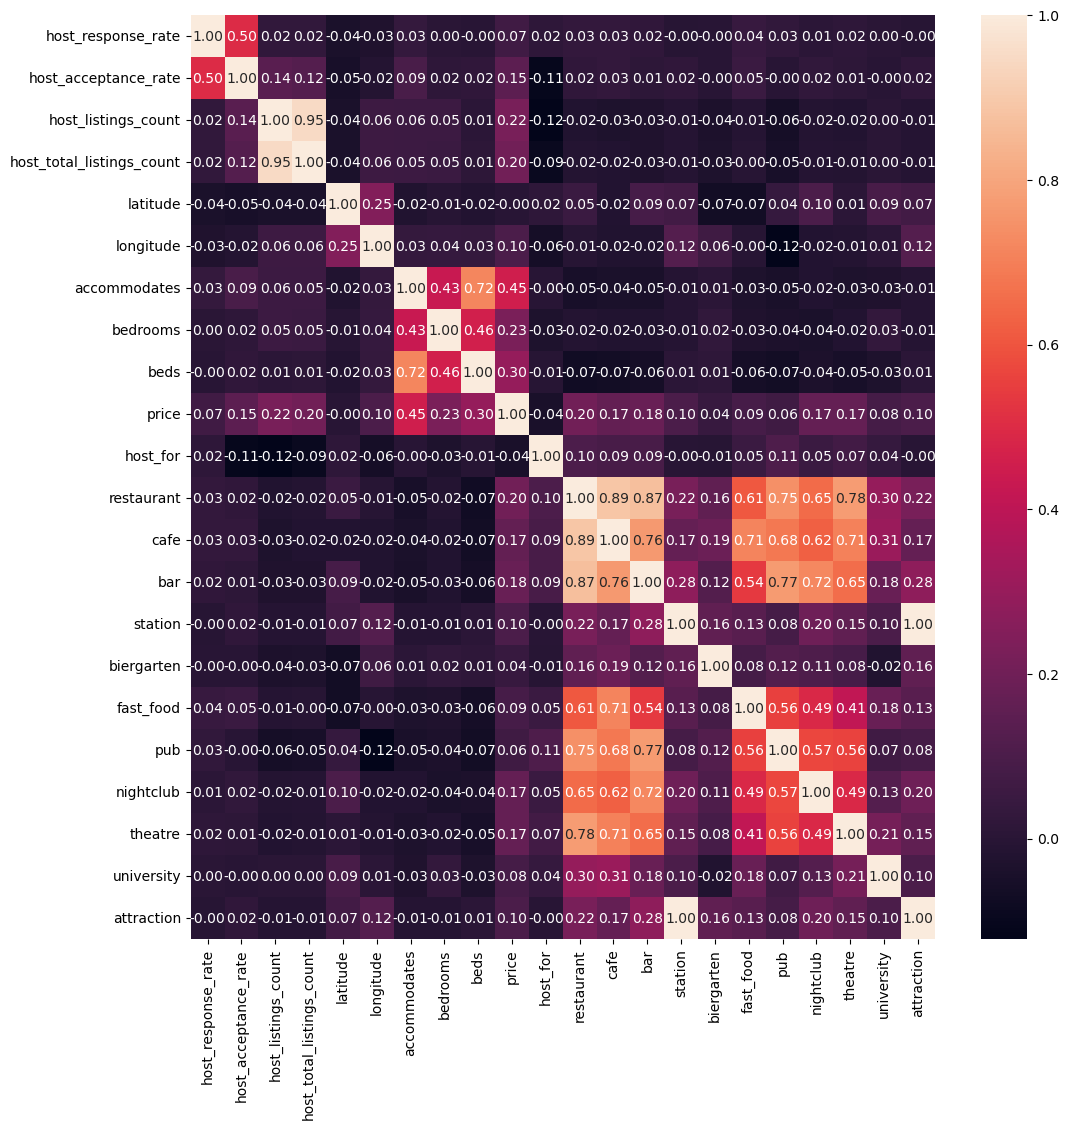

In [37]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(air_gdf.corr(), ax=ax, annot=True, fmt=".2f");
# fig.savefig("correlation-matrix.png") 

##### Visualization

In [ ]:
def add_amenities(fig, df, showlegend=True, name='', marker_color='rgb(135, 60, 200)', marker_size=5, marker='circle'):
    fig.add_scattermapbox(
        lat=df.lat.tolist(),
        lon=df.long.tolist(),
        #marker_symbol=marker,
        mode='markers', #'markers+text'
        #text=texts,
        #marker = marker,
        marker_size=marker_size,
        marker_color=marker_color,
        opacity= 0.8,
        showlegend=showlegend,
                #hover_data=['amenity'],
       # hoverinfo='restaurant'
      #  label={'trace 1':'test'},
        name=name)

def heatmap(df, title=''):
    """ selector specifies the geographic resolution 
    source: https://stackoverflow.com/questions/67680264/combining-mapbox-choropleth-with-additional-layers-and-markers-in-python-try-to
    additional markers : https://plotly.github.io/plotly.py-docs/generated/plotly.express.scatter_mapbox.html
    https://plotly.com/python/scatter-plots-on-maps/
    """
    feat_key = ''
    locations = ''
    hover_data = ''
    j = get_geo_data()
    fig = px.choropleth_mapbox(df, geojson=j, locations=test['name'], featureidkey="properties.name", color=test['value'],
                               title=title,
        mapbox_style="open-street-map", zoom=10, center = {"lat": 48.210033, "lon": 16.363449}, opacity=0.15)
    
    lons = [item['geometry']['coordinates'][0][0][0][1] for item in j['features']]
    lats = [item['geometry']['coordinates'][0][0][0][0] for item in j['features']]
    texts = [item['properties']['name'] for item in j['features']]

    marker = itertools.cycle(('circle')) 
    add_amenities(fig, fast_food, name='Restaurants', marker_color='rgb(240, 240, 200)', marker_size=12, marker=next(marker))
    add_amenities(fig, pub, name='Pubs', marker_color='rgb(255, 87, 200)', marker_size=1, marker=next(marker)) 
   
    add_amenities(fig, bar, name='Bar', marker_color='rgb(135, 60, 200)', marker_size=5, marker=next(marker))
    add_amenities(fig, cafe, name='Cafe', marker_color='rgb(135, 60, 200)', marker_size=7, marker=next(marker))    
    add_amenities(fig, fast_food, name='Fast food', marker_color='rgb(135, 60, 200)', marker_size=8, marker=next(marker)) 
    add_amenities(fig, station, name='Station', marker_color='rgb(135, 60, 200)', marker_size=6, marker=next(marker)) 
    add_amenities(fig, biergarten, name='Biergarten', marker_color='rgb(135, 60, 200)', marker_size=5, marker=next(marker)) 
    add_amenities(fig, attraction, name='Attraction', marker_color='rgb(135, 60, 200)', marker_size=5, marker=next(marker)) 
    add_amenities(fig, university, name='University', marker_color='rgb(40, 120, 43)', marker_size=2, marker=next(marker)) 
    add_amenities(fig, nightclub, name='Nightclub', marker_color='rgb(45, 67, 12)', marker_size=5, marker=next(marker))

    fig.update_coloraxes(showscale=False)
    fig.update_layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)')
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.update_layout(autosize=False,width=700,height=500)
    fig.show()

test = boundary_geojson.copy()

test.reset_index(inplace=True)
test['value'] =  test['index']*1.2
heatmap(boundary_geojson)

[0.07461567 0.12506132 0.08870853 0.10456704 0.1064217  0.09263052
 0.09809253 0.11941626 0.10669518 0.08379126]
RMSE: 36.776311
17    35.903184
Name: test-rmse-mean, dtype: float64


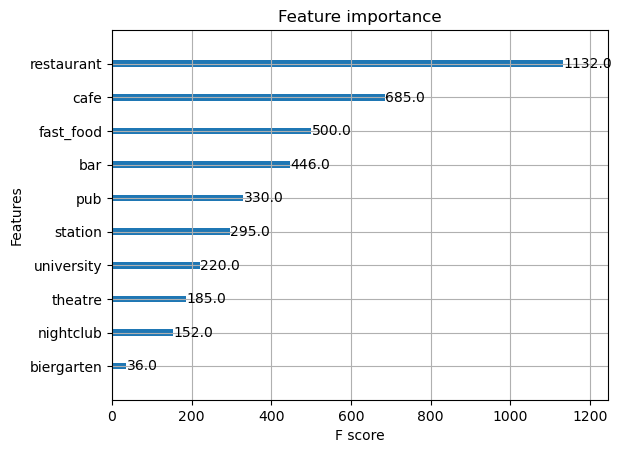

In [39]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, make_scorer

def display_results(cv, y_test, y_pred):
    """ check how well the model performs. """
    labels = np.unique(y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)
    accuracy = (y_pred == y_test).mean()

    print("Labels:", labels)
    print("Confusion Matrix:\n", confusion_mat)
    print("Accuracy:", accuracy)
    print("\nBest Parameters:", cv.best_params_)

def evaluate_model(model, X_test, y_test, category_names):
    """ evaluate how well the given model performs with test data set """
    y_pred = model.predict(X_test)

    class_report = classification_report(y_test, y_pred, target_names=category_names)
    print(class_report)

def save_model(model, model_filepath):
    """ save model as a .pkl file under a give file path """
    with open(model_filepath, 'wb') as file:
        pickle.dump(model, file)


# Separate the target variable and rest of the variables
X, y = air_gdf[['restaurant','cafe', 'bar', 'station','biergarten','fast_food','pub','nightclub',
                'theatre','university']], air_gdf['price']

# Convert the dataset into an optimized data structure called Dmatrix that XGBoost supports and gives it acclaimed performance and efficiency gains. You will use this later in the tutorial.
data_dmatrix = xgb.DMatrix(data=X,label=y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)
model = xgb.XGBRegressor()

model.fit(X_train,y_train)

save_model(model, os.path.join(Path(cwd).parent, 'model', 'xboost.pkl'))

# feature importance
print(model.feature_importances_)
preds = model.predict(X_test)

# Compute the rmse by invoking the mean_sqaured_error function from sklearn's metrics module.
rmse = np.sqrt(mean_squared_error(y_test, preds))

params = {}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

print("RMSE: %f" % (rmse))
print((cv_results["test-rmse-mean"]).tail(1))

xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [6, 6]
plt.show()

In [40]:
# example to predict benchmark price
d = {'restaurant': 3, 'cafe': 100, 'bar':5, 'station':3, 'biergarten':1, 'fast_food':15, 'pub':3,
    'nightclub':1,'theatre':0,'university':0}
X_pred = pd.DataFrame(data=d, index=[0])
preds = model.predict(X_pred)
print(preds)

[42.688633]


### Results

In my final XGBoost model, as you can see below, these OSM features (highlighted in red) ended up being some of the most important drivers of price in London.


#### Convert notebook to html
```python
!jupyter nbconvert --to html Airbnb-Analysis.ipynb
```

In [42]:
# download notebook to html
!jupyter nbconvert --to html Airbnb-Analysis.ipynb

[NbConvertApp] Converting notebook Airbnb-Analysis.ipynb to html
[NbConvertApp] Writing 35953514 bytes to Airbnb-Analysis.html
